In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from preprocessors import x_cord_contour, makeSquare, resize_to_pixel

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]

In [3]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [4]:
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print ("Number of Classes: " + str(y_test.shape[1]))

Number of Classes: 10


In [8]:
num_classes = y_test.shape[1]
num_pixels = x_train.shape[1] * x_train.shape[2]

In [9]:
# create model
model = Sequential()

# 2 sets of CRP (Convolution, RELU, Pooling)
model.add(Conv2D(20, (5, 5), padding = "same", activation='relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(50, (5, 5), padding = "same", activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# Fully connected layers (w/ RELU)
model.add(Flatten())
model.add(Dense(500, activation='relu'))

# Softmax (for classification)
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5010      
Total para

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adadelta(), metrics = ['accuracy'])

In [11]:
# Training Parameters
batch_size = 128
epochs = 10

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

model.save("trained_model/mnist_LeNet.h5")

# Evaluate the performance of our trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 144s 2ms/step - loss: 0.1788 - acc: 0.9430 - val_loss: 0.0451 - val_acc: 0.9850
Epoch 2/10
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0439 - acc: 0.9862 - val_loss: 0.0312 - val_acc: 0.9903
Epoch 3/10
60000/60000 [==============================] - 143s 2ms/step - loss: 0.0285 - acc: 0.9908 - val_loss: 0.0261 - val_acc: 0.9916
Epoch 4/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0206 - acc: 0.9936 - val_loss: 0.0208 - val_acc: 0.9940
Epoch 5/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0239 - val_acc: 0.9926
Epoch 6/10
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0108 - acc: 0.9967 - val_loss: 0.0215 - val_acc: 0.9926
Epoch 7/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0090 - acc: 0.9975 - val_loss: 0.0212 - 

In [13]:
model1 = load_model('trained_model/mnist_LeNet.h5')

In [14]:
def check_test():    
    for i in range(10):
        rand = np.random.randint(0, len(x_test))
        input_im  = x_test[rand]
        imgplot = plt.imshow(np.squeeze(input_im))
        plt.axis('off')
        plt.show()

        imageL = cv2.resize(input_im, None, fx=4, fy=4, interpolation = cv2.INTER_CUBIC) 
        input_im = input_im.reshape(1,28,28,1) 
        print("Prediction:", str(model1.predict_classes(input_im, 1, verbose = 0)[0]))

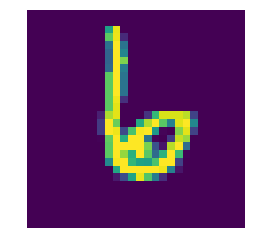

Prediction: 6


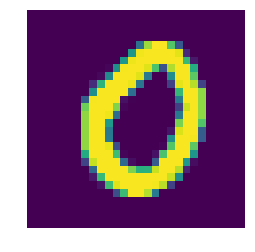

Prediction: 0


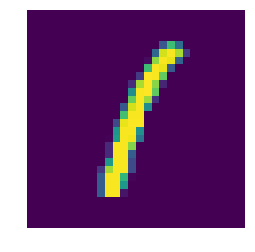

Prediction: 1


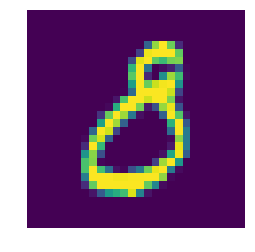

Prediction: 8


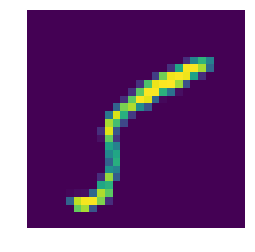

Prediction: 5


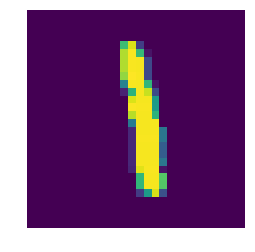

Prediction: 1


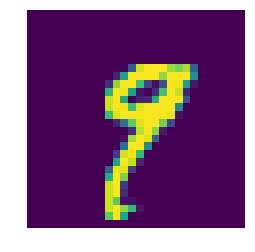

Prediction: 9


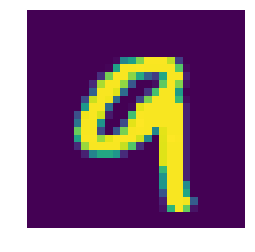

Prediction: 9


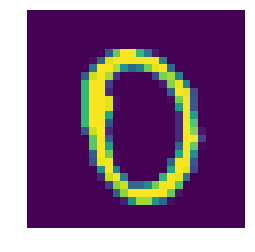

Prediction: 0


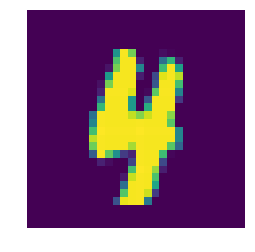

Prediction: 4


In [15]:
check_test()

In [16]:
def check(i):    
    image = cv2.imread(i)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    
    _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = x_cord_contour, reverse = False)

    full_number = []

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)    

        if w >= 5 and h >= 25:
            roi = blurred[y:y + h, x:x + w]
            ret, roi = cv2.threshold(roi, 127, 255,cv2.THRESH_BINARY_INV)
            roi = makeSquare(roi)
            roi = resize_to_pixel(28, roi)
            roi = roi / 255.0       
            roi = roi.reshape(1,28,28,1) 

            res = str(model1.predict_classes(roi, 1, verbose = 0)[0])
            full_number.append(res)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(image, res, (x , y + 155), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0), 2) 

    cv2.destroyAllWindows()
    imgplot = plt.imshow(image)
    plt.axis('off')
    plt.show()
    print ("The number is: " + ''.join(full_number))

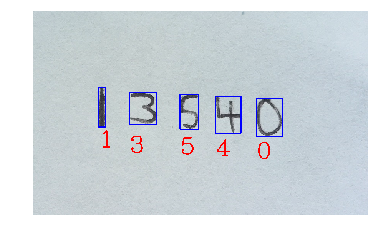

The number is: 13540


In [17]:
check('test/numbers.jpg')

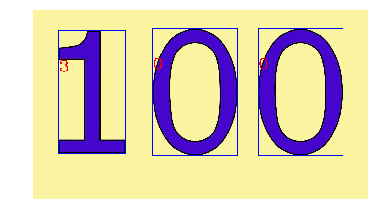

The number is: 300


In [18]:
check('test/100.jpg')

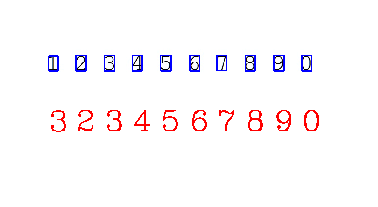

The number is: 3234567890


In [19]:
check('test/check2.jpg')

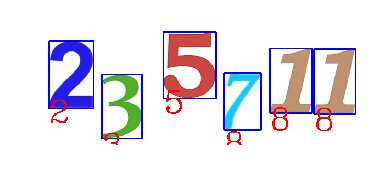

The number is: 235888


In [20]:
check('test/check3.webp')

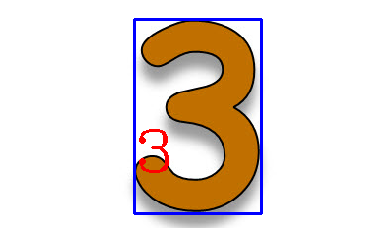

The number is: 3


In [21]:
check('test/number-3_4.jpg')

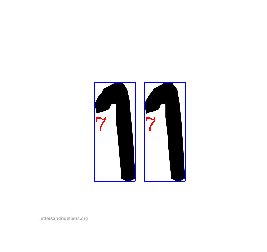

The number is: 77


In [24]:
check('test/11.jpg')

In [25]:
check('test/4.jpg')

ZeroDivisionError: float division by zero